In [2]:
import numpy as np
import pandas as pd
import torch
# num = []
# i=0
# while i<6:
#     num.append((np.random.randint(1,101,size=3)*.01).tolist())
#     i+=1
# inputs = torch.tensor(num)
inputs = torch.tensor([
    [.43,.15,.89],
    [.55,.87,.66],
    [.57,.85,.64],
    [.22,.58,.33],
    [.77,.25,.10],
    [.05,.80,.55]
])


In [3]:
print(inputs)

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])


In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

words = ['Your','journey','starts','with','one','step']  ##Each word will represent each row in above tensor


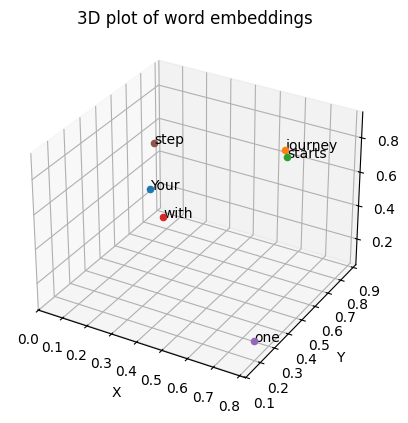

In [5]:
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

#Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

for x, y, z, word in zip(x_coords,y_coords,z_coords, words):
    ax.scatter(x,y,z)
    ax.text(x,y,z,word,fontsize=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D plot of word embeddings')
plt.show()

(0.0, 1.0)

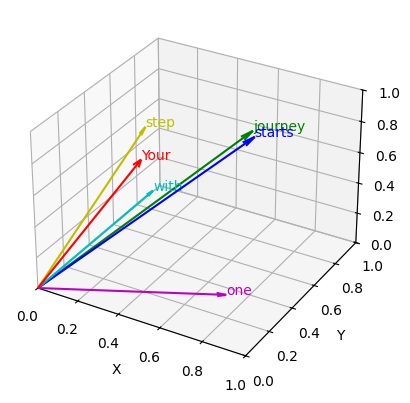

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

colors = ['r','g','b','c','m','y']

for (x,y,z,word,color) in zip(x_coords, y_coords,z_coords,words,colors):
    ax.quiver(0,0,0,x,y,z, color=color, arrow_length_ratio=.05)
    ax.text(x,y,z,word,fontsize=10,color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])

In [7]:
# Each row represents a word, and each column represents an embedding dimension
# second input token serves as the query
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i,query)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [8]:
attn_weights_2_tmp = attn_scores_2/attn_scores_2.sum()
print("Attention Weights:",attn_weights_2_tmp)
print(sum(attn_weights_2_tmp))

Attention Weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
tensor(1.0000)


On a extreme values in our dataset might lead to overflow or underflow in data, cause on using Naive softmax

In [ ]:
def softmax_naive(x):
    return torch.exp(x)/torch.exp(x).sum(dim=0) ##dim=0 used, entire row is taken into consideration for summation

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention Weights",attn_weights_2_naive)
print("Tot:",sum(attn_weights_2_naive))

Attention Weights tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Tot: tensor(1.0000)


on a normal data both pytorch, and naive works similarly but on extreme data pytorch's softmax could handle the extreme values to go for overflow or underflow

In [10]:
attn_weights_2 = torch.softmax(attn_scores_2,dim=0)
print("Attention weights by softmax",attn_weights_2)
print("sum:",attn_weights_2.sum())

Attention weights by softmax tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum: tensor(1.)


will calculate Context vector

In [11]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,X_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)


tensor([0.0500, 0.8000, 0.5500])


Lets follow similar steps in calculating attention scores for each query vectors

In [12]:
attn_score = torch.empty(6,6)
for i,x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_score[i,j] = torch.dot(x_i,x_j)
print(attn_score)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


When computing the attention scores, using for loops are generally slower and computationally heavier.
instead using matrix multiplication we can achieve the same results without any issues

In [15]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [17]:
attn_weights = torch.softmax(attn_score, dim=-1) ##its applied accross columns for a single row at a time. by giving -1 softmax 
                ##apply normalization along the last dimension. in short if we sum up entire row will get 1.
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [35]:
lst = torch.tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452]])
print(lst.sum(dim=-1))
attn_weights.sum(dim=0)

tensor([0.9999])


tensor([0.9220, 1.2970, 1.2788, 0.7974, 0.7540, 0.9508])

In [36]:
att_context_vec = attn_weights @ inputs 
print(att_context_vec)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
